Я собираюсь предсказывать цену сумки на перепродаже по её характеристикам. Я строю несколько моделей и в качестве оценки корректности их работы минимизирую среднеквадратичную ошибку

In [29]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import HuberRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso, Ridge

import warnings
warnings.filterwarnings("ignore")

---

In [2]:
df = pd.read_csv('df_new_factors.csv')
print(df.shape)
df.head()

(1051, 16)


,Размер,Категория,Бренд,Материал сумок,Цвет,Длина ручки,Наличие пыльника,Состояние товара,Модель,Винтаж,Наличие коробки,Наличие сертификата,Ценовая категория,Метод производства,Легенда,Цена
0,INT L,Сумки с короткими ручками,MARC JACOBS,Экзотическая кожа,Серебряный,Средние ручки,1,Отличное состояние,Ordinary,0,0,0,Дорогие,Произведенные на фабрике,0,52000
1,INT S,Клатчи и вечерние сумки,VERSACE,Кожа,Черный,Короткие ручки,0,Отличное состояние,Ordinary,0,0,0,Дорогие,Произведенные на фабрике,0,38000
2,INT M,Сумки через плечо,BALENCIAGA,Кожа,Желтый,Длинный ремень,0,Новое с биркой,Crush,0,0,0,Люксовые,Произведенные на фабрике,1,345000
3,INT U,Сумки с короткими ручками,BURBERRY,Кожа,Коричневый,Средние ручки,0,Отличное состояние,Ordinary,1,0,0,Люксовые,Произведенные на фабрике,0,27000
4,INT M,Сумки с короткими ручками,KARL LAGERFELD,Искусственная кожа,Мульти,Средние ручки,0,Новое с биркой,Ordinary,0,0,0,Доступные,Произведенные на фабрике,0,17950


In [102]:
# Разобъем данные на обучающую и тестовую выборку в пропорции 7:3
y = df["Цена"]
X = df.drop(columns=["Цена"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1890, stratify=X['Ценовая категория'])

In [103]:
X.isnull().sum()

Размер                 0
Категория              0
Бренд                  0
Материал сумок         0
Цвет                   0
Длина ручки            0
Наличие пыльника       0
Состояние товара       0
Модель                 0
Винтаж                 0
Наличие коробки        0
Наличие сертификата    0
Ценовая категория      0
Метод производства     0
Легенда                0
dtype: int64

In [104]:
# Для визуализации
sort_mask_train = np.argsort(y_train.to_numpy())
sort_mask_test = np.argsort(y_test.to_numpy())

##  Обрабатываем категориальные признаки

In [105]:
categorical_features = ['Размер', 'Категория', 'Бренд', 'Материал сумок', 'Цвет', 'Длина ручки', 'Состояние товара', 'Ценовая категория', 'Метод производства']

In [106]:
column_transformer = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features)])

In [107]:
X_train_scaled = pd.DataFrame(column_transformer.fit_transform(X_train).toarray())
X_test_scaled = pd.DataFrame(column_transformer.transform(X_test).toarray())

In [108]:
feature_names = column_transformer.get_feature_names_out()
feature_names

array(['ohe__Размер_INT M', 'ohe__Размер_INT S', 'ohe__Размер_INT U',
       'ohe__Размер_INT XL', 'ohe__Размер_INT XS',
       'ohe__Категория_Клатчи и вечерние сумки',
       'ohe__Категория_Пляжные сумки', 'ohe__Категория_Поясные сумки',
       'ohe__Категория_Рюкзаки',
       'ohe__Категория_Сумки с короткими ручками',
       'ohe__Категория_Сумки тоут', 'ohe__Категория_Сумки через плечо',
       'ohe__Бренд_ADIDAS BY STELLA MCCARTNEY', 'ohe__Бренд_AGNONA',
       'ohe__Бренд_ALEXANDER MCQUEEN', 'ohe__Бренд_BALENCIAGA',
       'ohe__Бренд_BALMAIN', 'ohe__Бренд_BOTTEGA VENETA',
       'ohe__Бренд_BURBERRY', 'ohe__Бренд_BVLGARI', 'ohe__Бренд_BY FAR',
       'ohe__Бренд_CALVIN KLEIN', 'ohe__Бренд_CEDRIC CHARLIER',
       'ohe__Бренд_CELINE PRE-OWNED', 'ohe__Бренд_CHANEL PRE-OWNED',
       'ohe__Бренд_CHARLOTTE OLYMPIA', 'ohe__Бренд_CHLOE',
       'ohe__Бренд_CHRISTIAN DIOR PRE-OWNED', 'ohe__Бренд_COACH',
       'ohe__Бренд_COCCINELLE', 'ohe__Бренд_COMME DES GARÇONS',
       'ohe__Брен

---

## Линейная регрессия

## 1. Базовая модель

In [109]:
lr_base = LinearRegression()
lr_base.fit(X_train_scaled, y_train)

y_train_pred = lr_base.predict(X_train_scaled)
y_pred = lr_base.predict(X_test_scaled)

In [110]:
print(f"Train MSE = {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE = {mean_squared_error(y_test, y_pred)}")
print()
print(f"Train MAE = {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE = {mean_absolute_error(y_test, y_pred)}")

Train MSE = 74159868533.31293
Test MSE = 1.8545303937589475e+31

Train MAE = 127749.32108843538
Test MAE = 640947497858655.8


Ошибка на тесте намного выше, чем на на тренировочных данных, что свидетельствует о переобучении. Ужасный результат! Пробуем другие методы.

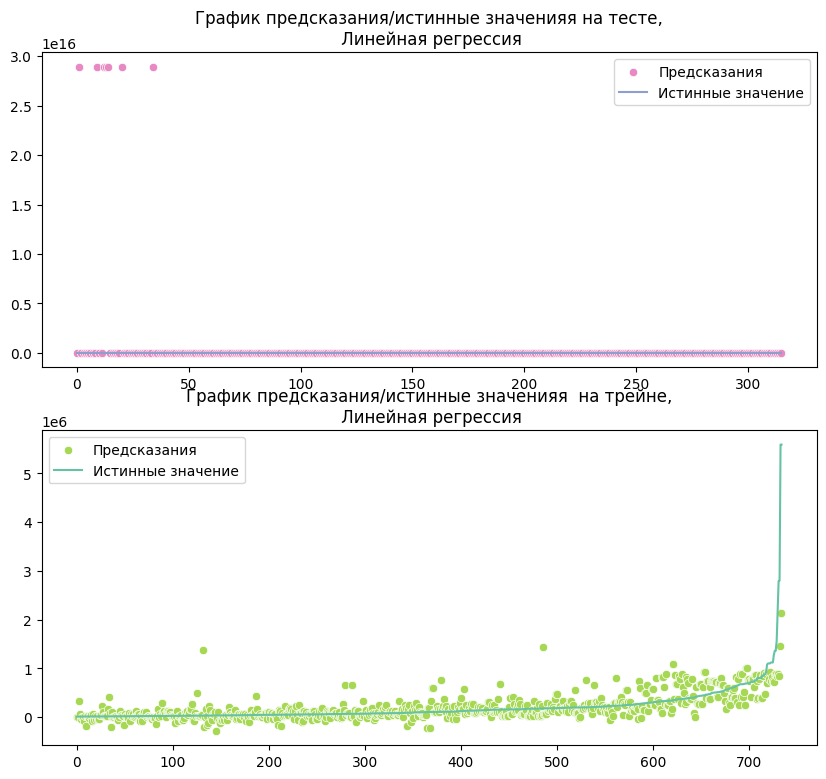

In [111]:
colors = sns.color_palette('Set2', 5)

plt.figure(figsize = (10,9))

plt.subplot(2,1,1)
plt.title('График предсказания/истинные значенияя на тесте,\n Линейная регрессия')
sns.scatterplot(x = range(len(y_pred)), y = y_pred[sort_mask_test], color = colors[3], label = 'Предсказания')
sns.lineplot(x = range(len(y_test)), y = y_test.to_numpy()[sort_mask_test], 
             color = colors[2], label = 'Истинные значение')

plt.subplot(2,1,2)
plt.title('График предсказания/истинные значенияя  на трейне,\n Линейная регрессия')
sns.scatterplot(x = range(len(y_train_pred)), y = y_train_pred[sort_mask_train], color = colors[4], label = 'Предсказания')
sns.lineplot(x = range(len(y_train)), y = y_train.to_numpy()[sort_mask_train], color = colors[0], label = 'Истинные значение')

plt.legend()
plt.show()

## 2. Lasso-регрессия

In [118]:
alphas = np.linspace(10000,30000, 400)

lasso_GS = GridSearchCV(
    Lasso(),
    param_grid={'alpha': alphas}
)

lasso_GS.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': array([10000.        , 10050.12531328, 10100.25062657, 10150.37593985,
       10200.50125313, 10250.62656642, 10300.7518797 , 10350.87719298,
       10401.00250627, 10451.12781955, 10501.25313283, 10551.37844612,
       10601.5037594 , 10651.62907268, 10701.75438596, 10751.87969925,
       10802.00501253, 10852.13032581, 10902.2556391 , 10952.38095238,
       110...
       28847.11779449, 28897.24310777, 28947.36842105, 28997.49373434,
       29047.61904762, 29097.7443609 , 29147.86967419, 29197.99498747,
       29248.12030075, 29298.24561404, 29348.37092732, 29398.4962406 ,
       29448.62155388, 29498.74686717, 29548.87218045, 29598.99749373,
       29649.12280702, 29699.2481203 , 29749.37343358, 29799.49874687,
       29849.62406015, 29899.74937343, 29949.87468672, 30000.        ])})

In [119]:
best_alpha = lasso_GS.best_params_['alpha']
best_alpha

20576.441102756893

In [120]:
# обучаем лучшую модель
lasso_lr = Lasso(alpha=best_alpha)
lasso_lr.fit(X_train_scaled, y_train)

Lasso(alpha=20576.441102756893)

In [121]:
y_train_pred = lasso_lr.predict(X_train_scaled)
y_pred = lasso_lr.predict(X_test_scaled)

In [122]:
print(f"Train MSE = {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE = {mean_squared_error(y_test, y_pred)}")
print()
print(f"Train MAE = {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE = {mean_absolute_error(y_test, y_pred)}")

Train MSE = 113837173552.56519
Test MSE = 52887739707.67532

Train MAE = 141970.92457344584
Test MAE = 138975.56631572687


In [123]:
# Веса
lasso_lr_feature_coefs = pd.DataFrame(
    data=lasso_lr.coef_, index=feature_names, columns=['Coef']
)

lasso_lr_feature_coefs

,Coef
ohe__Размер_INT M,-0.000000
ohe__Размер_INT S,-0.000000
ohe__Размер_INT U,0.000000
ohe__Размер_INT XL,-0.000000
ohe__Размер_INT XS,0.000000
...,...
ohe__Ценовая категория_Доступный люкс,-0.000000
ohe__Ценовая категория_Люксовые,0.000000
ohe__Ценовая категория_Экстремально люксовые,364861.994899
ohe__Метод производства_Произведенные на фабрике,-0.000000


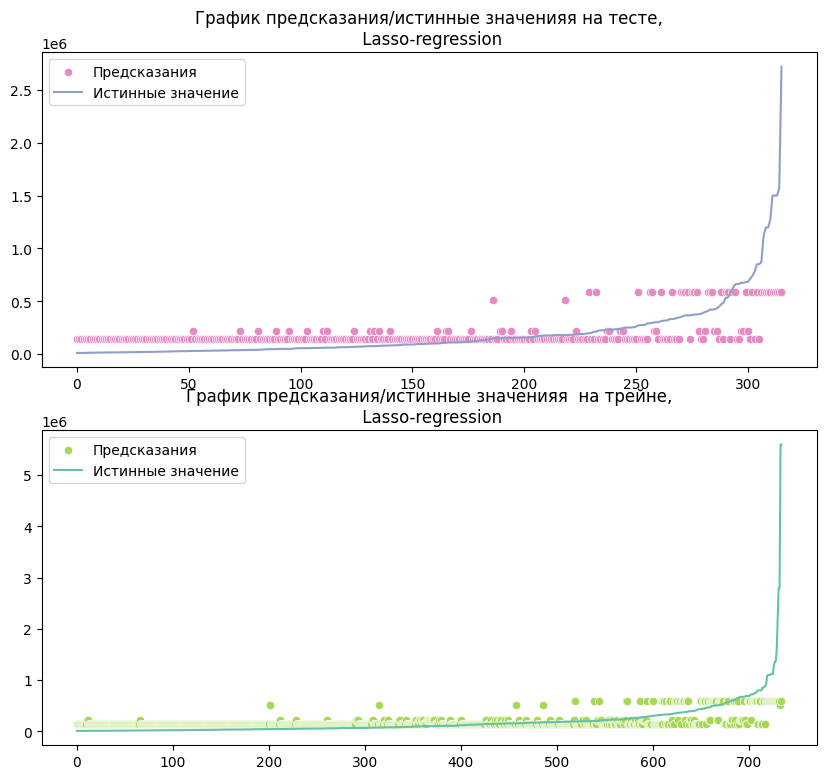

In [124]:
colors = sns.color_palette('Set2', 5)

plt.figure(figsize = (10,9))

plt.subplot(2,1,1)
plt.title('График предсказания/истинные значенияя на тесте,\n Lasso-regression')
sns.scatterplot(x = range(len(y_pred)), y = y_pred[sort_mask_test], color = colors[3], label = 'Предсказания')
sns.lineplot(x = range(len(y_test)), y = y_test.to_numpy()[sort_mask_test], 
             color = colors[2], label = 'Истинные значение')

plt.subplot(2,1,2)
plt.title('График предсказания/истинные значенияя  на трейне,\n Lasso-regression')
sns.scatterplot(x = range(len(y_train_pred)), y = y_train_pred[sort_mask_train], color = colors[4], label = 'Предсказания')
sns.lineplot(x = range(len(y_train)), y = y_train.to_numpy()[sort_mask_train], color = colors[0], label = 'Истинные значение')

plt.legend()
plt.show()

**Вывод:** результаты значительно лучше, чем у обычной регрессии

## 3. Ridge-регрессия

In [125]:
# Подберем оптимальные гиперпараметры модели
solvers = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']

solver_GS = GridSearchCV(
    Ridge(),
    param_grid={'solver': solvers}
)

solver_GS.fit(X_train_scaled, y_train)
best_solver = solver_GS.best_params_['solver']
best_solver

'lsqr'

In [136]:
alphas = np.linspace(20,100, 40)

ridge_GS = GridSearchCV(
    Ridge(solver=best_solver),
    param_grid={'alpha': alphas}
)

ridge_GS.fit(X_train_scaled, y_train)

GridSearchCV(estimator=Ridge(solver='lsqr'),
             param_grid={'alpha': array([ 20.        ,  22.05128205,  24.1025641 ,  26.15384615,
        28.20512821,  30.25641026,  32.30769231,  34.35897436,
        36.41025641,  38.46153846,  40.51282051,  42.56410256,
        44.61538462,  46.66666667,  48.71794872,  50.76923077,
        52.82051282,  54.87179487,  56.92307692,  58.97435897,
        61.02564103,  63.07692308,  65.12820513,  67.17948718,
        69.23076923,  71.28205128,  73.33333333,  75.38461538,
        77.43589744,  79.48717949,  81.53846154,  83.58974359,
        85.64102564,  87.69230769,  89.74358974,  91.79487179,
        93.84615385,  95.8974359 ,  97.94871795, 100.        ])})

In [137]:
best_alpha = ridge_GS.best_params_['alpha']
best_alpha

34.35897435897436

In [138]:
ridge_lr = Ridge(solver=best_solver, alpha=best_alpha)
ridge_lr.fit(X_train_scaled, y_train)

Ridge(alpha=34.35897435897436, solver='lsqr')

In [139]:
y_train_pred = ridge_lr.predict(X_train_scaled)
y_pred = ridge_lr.predict(X_test_scaled)

In [140]:
print(f"Train MSE = {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE = {mean_squared_error(y_test, y_pred)}")
print()
print(f"Train MAE = {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE = {mean_absolute_error(y_test, y_pred)}")

Train MSE = 89197484502.66684
Test MSE = 45185694584.04062

Train MAE = 118323.0122213247
Test MAE = 121507.71398636056


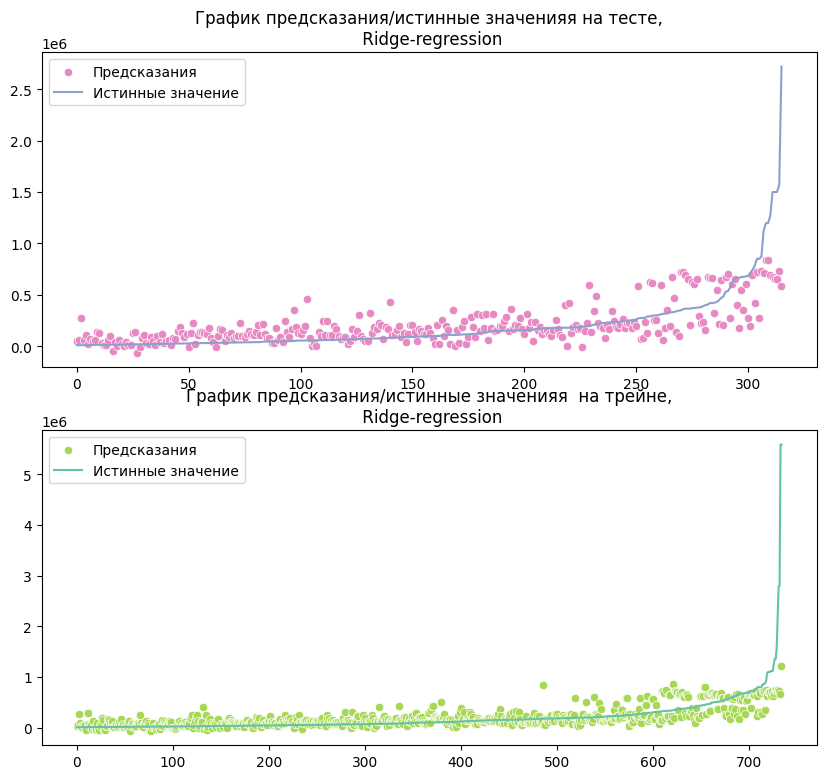

In [141]:
colors = sns.color_palette('Set2', 5)

plt.figure(figsize = (10,9))

plt.subplot(2,1,1)
plt.title('График предсказания/истинные значенияя на тесте,\n Ridge-regression')
sns.scatterplot(x = range(len(y_pred)), y = y_pred[sort_mask_test], color = colors[3], label = 'Предсказания')
sns.lineplot(x = range(len(y_test)), y = y_test.to_numpy()[sort_mask_test], 
             color = colors[2], label = 'Истинные значение')

plt.subplot(2,1,2)
plt.title('График предсказания/истинные значенияя  на трейне,\n Ridge-regression')
sns.scatterplot(x = range(len(y_train_pred)), y = y_train_pred[sort_mask_train], color = colors[4], label = 'Предсказания')
sns.lineplot(x = range(len(y_train)), y = y_train.to_numpy()[sort_mask_train], color = colors[0], label = 'Истинные значение')

plt.legend()
plt.show()

**Вывод:** результаты ещё чуть улучшились, но далеки от идеала.

## Стохастический градиентный спуск

In [143]:
# подбор гиперпараметров модели
av_loss = ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']

loss_GS = GridSearchCV(
    estimator=SGDRegressor(),
    param_grid={'loss': av_loss}
)

best_loss = loss_GS.fit(X_train_scaled, y_train).best_params_['loss']
best_loss

'squared_error'

In [144]:
alphas = np.linspace(20, 100, 40)
penalties = ['l2', 'l1', 'elasticnet']

sgd_GS = GridSearchCV(
    estimator=SGDRegressor(loss=best_loss),
    param_grid={
        'penalty': penalties,
        'alpha': alphas
    }
)

sgd_GS.fit(X_train_scaled, y_train)

GridSearchCV(estimator=SGDRegressor(),
             param_grid={'alpha': array([ 20.        ,  22.05128205,  24.1025641 ,  26.15384615,
        28.20512821,  30.25641026,  32.30769231,  34.35897436,
        36.41025641,  38.46153846,  40.51282051,  42.56410256,
        44.61538462,  46.66666667,  48.71794872,  50.76923077,
        52.82051282,  54.87179487,  56.92307692,  58.97435897,
        61.02564103,  63.07692308,  65.12820513,  67.17948718,
        69.23076923,  71.28205128,  73.33333333,  75.38461538,
        77.43589744,  79.48717949,  81.53846154,  83.58974359,
        85.64102564,  87.69230769,  89.74358974,  91.79487179,
        93.84615385,  95.8974359 ,  97.94871795, 100.        ]),
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [145]:
best_alpha, best_penalty = sgd_GS.best_params_.values()
best_alpha, best_penalty

(54.87179487179487, 'l1')

In [146]:
sgd_lr = SGDRegressor(loss=best_loss, alpha=best_alpha, penalty=best_penalty)
sgd_lr.fit(X_train_scaled, y_train)

SGDRegressor(alpha=54.87179487179487, penalty='l1')

In [147]:
y_train_pred = sgd_lr.predict(X_train_scaled)
y_pred = sgd_lr.predict(X_test_scaled)

In [148]:
print(f"Train MSE = {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE = {mean_squared_error(y_test, y_pred)}")
print()
print(f"Train MAE = {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE = {mean_absolute_error(y_test, y_pred)}")

Train MSE = 77557448544.88307
Test MSE = 51265515985.791756

Train MAE = 127947.66661991626
Test MAE = 136202.32046045942


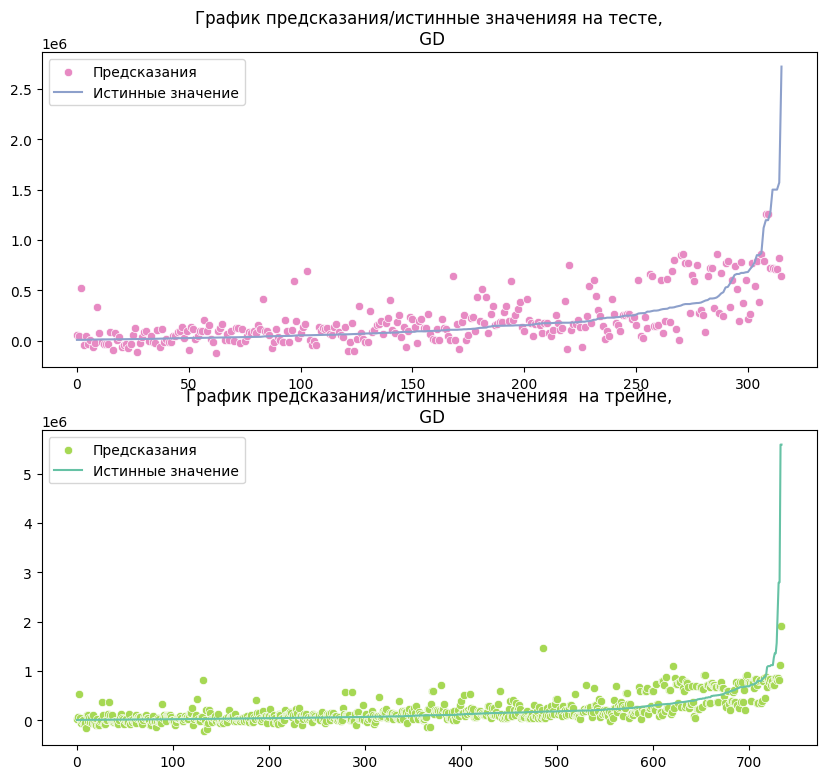

In [149]:
colors = sns.color_palette('Set2', 5)

plt.figure(figsize = (10,9))

plt.subplot(2,1,1)
plt.title('График предсказания/истинные значенияя на тесте,\n GD')
sns.scatterplot(x = range(len(y_pred)), y = y_pred[sort_mask_test], color = colors[3], label = 'Предсказания')
sns.lineplot(x = range(len(y_test)), y = y_test.to_numpy()[sort_mask_test], 
             color = colors[2], label = 'Истинные значение')

plt.subplot(2,1,2)
plt.title('График предсказания/истинные значенияя  на трейне,\n GD')
sns.scatterplot(x = range(len(y_train_pred)), y = y_train_pred[sort_mask_train], color = colors[4], label = 'Предсказания')
sns.lineplot(x = range(len(y_train)), y = y_train.to_numpy()[sort_mask_train], color = colors[0], label = 'Истинные значение')

plt.legend()
plt.show()

**Вывод:** примерно то же самое

##  Случайный лес

In [150]:
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf_GS = GridSearchCV(
    RandomForestRegressor(), param_grid, cv=4, scoring='neg_mean_squared_error'
)

rf_GS.fit(X_train_scaled, y_train);

In [151]:
rf_GS.best_params_

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

In [152]:
best_max_depth, best_min_samples_split, best_n_estimators = rf_GS.best_params_.values()
best_max_depth, best_min_samples_split, best_n_estimators

(10, 2, 200)

In [153]:
rf_model = RandomForestRegressor(
    n_estimators=best_n_estimators, min_samples_split=best_min_samples_split, max_depth=best_max_depth
)

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200)

In [154]:
y_train_pred = rf_model.predict(X_train_scaled)
y_pred = rf_model.predict(X_test_scaled)

In [155]:
print(f"Train MSE = {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE = {mean_squared_error(y_test, y_pred)}")
print()
print(f"Train MAE = {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE = {mean_absolute_error(y_test, y_pred)}")

Train MSE = 9378218361.91427
Test MSE = 70952344799.72147

Train MAE = 43612.394107027685
Test MAE = 84710.56910919641


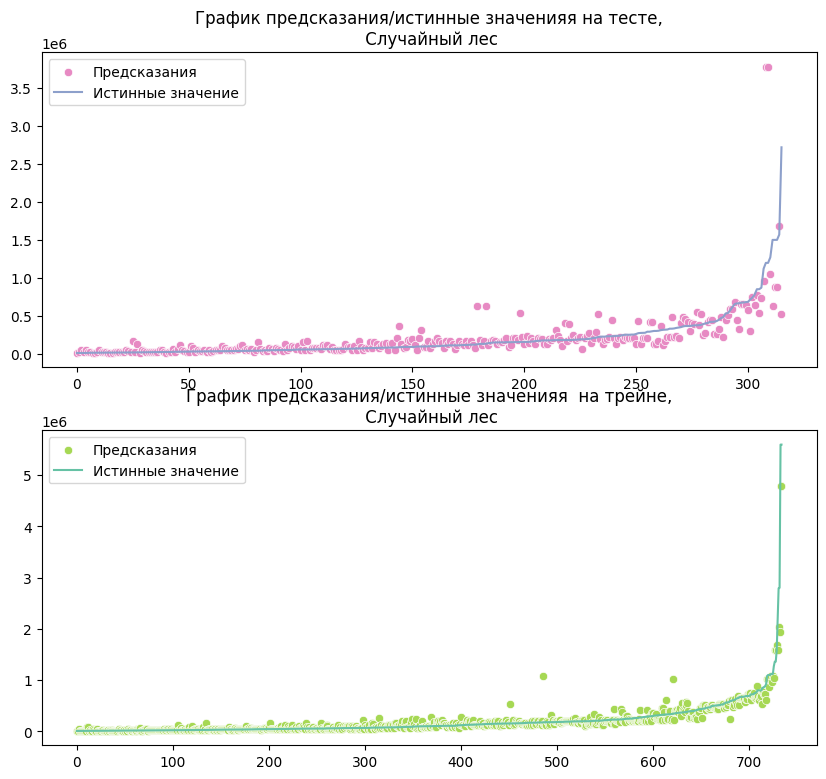

In [156]:
colors = sns.color_palette('Set2', 5)

plt.figure(figsize = (10,9))

plt.subplot(2,1,1)
plt.title('График предсказания/истинные значенияя на тесте,\n Случайный лес')
sns.scatterplot(x = range(len(y_pred)), y = y_pred[sort_mask_test], color = colors[3], label = 'Предсказания')
sns.lineplot(x = range(len(y_test)), y = y_test.to_numpy()[sort_mask_test], 
             color = colors[2], label = 'Истинные значение')

plt.subplot(2,1,2)
plt.title('График предсказания/истинные значенияя  на трейне,\n Случайный лес')
sns.scatterplot(x = range(len(y_train_pred)), y = y_train_pred[sort_mask_train], color = colors[4], label = 'Предсказания')
sns.lineplot(x = range(len(y_train)), y = y_train.to_numpy()[sort_mask_train], color = colors[0], label = 'Истинные значение')

plt.legend()
plt.show()

In [157]:
rf_model_feature_coefs = pd.DataFrame(
    data=rf_model.feature_importances_, index=feature_names, columns=['Coef']
)

rf_model_feature_coefs

,Coef
ohe__Размер_INT M,0.007808
ohe__Размер_INT S,0.012365
ohe__Размер_INT U,0.019787
ohe__Размер_INT XL,0.000012
ohe__Размер_INT XS,0.016325
...,...
ohe__Ценовая категория_Доступный люкс,0.001743
ohe__Ценовая категория_Люксовые,0.040422
ohe__Ценовая категория_Экстремально люксовые,0.186462
ohe__Метод производства_Произведенные на фабрике,0.008508


**Вывод:** Вау!!! Все уже намного лучше, модель предсказывает цены даже для крайне дорогих сумок, что раньше она не могла. И я не вижу признаков переобучения

## Градиентный бустинг

Этот алгоритм жадно и последовательно строит композицию базовых моделей и каждая следующая модель строится так, чтобы максимально корректировать ошибки предыдущей 

In [158]:

btg_raw_model_GS = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid={'n_estimators': [50, 100, 150, 200]}
)

btg_raw_model_GS.fit(X_train_scaled, y_train)

best_n_estimators = btg_raw_model_GS.best_params_['n_estimators']
best_n_estimators

150

In [159]:
btg_model_GS = GridSearchCV(
    estimator=GradientBoostingRegressor(n_estimators=best_n_estimators),
    param_grid={
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 5, 10, 15],
        'max_depth': [3, 5, 10, 15]
    }
)

btg_model_GS.fit(X_train_scaled, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(n_estimators=150),
             param_grid={'max_depth': [3, 5, 10, 15],
                         'min_samples_leaf': [1, 5, 10, 15],
                         'min_samples_split': [2, 5, 10, 15]})

In [160]:
btg_model_GS.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 15}

In [161]:
best_max_depth, best_min_samples_leaf, best_min_samples_split = btg_model_GS.best_params_.values()

In [162]:
btg_model = GradientBoostingRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    min_samples_split=best_min_samples_split
)

btg_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=15, min_samples_split=15, n_estimators=150)

In [163]:
y_train_pred = btg_model.predict(X_train_scaled)
y_pred = btg_model.predict(X_test_scaled)

In [164]:
print(f"Train MSE = {mean_squared_error(y_train, y_train_pred)}")
print(f"Test MSE = {mean_squared_error(y_test, y_pred)}")
print()
print(f"Train MAE = {mean_absolute_error(y_train, y_train_pred)}")
print(f"Test MAE = {mean_absolute_error(y_test, y_pred)}")

Train MSE = 1455622416.5700696
Test MSE = 138311410544.33987

Train MAE = 8643.756110381508
Test MAE = 82722.5135585783


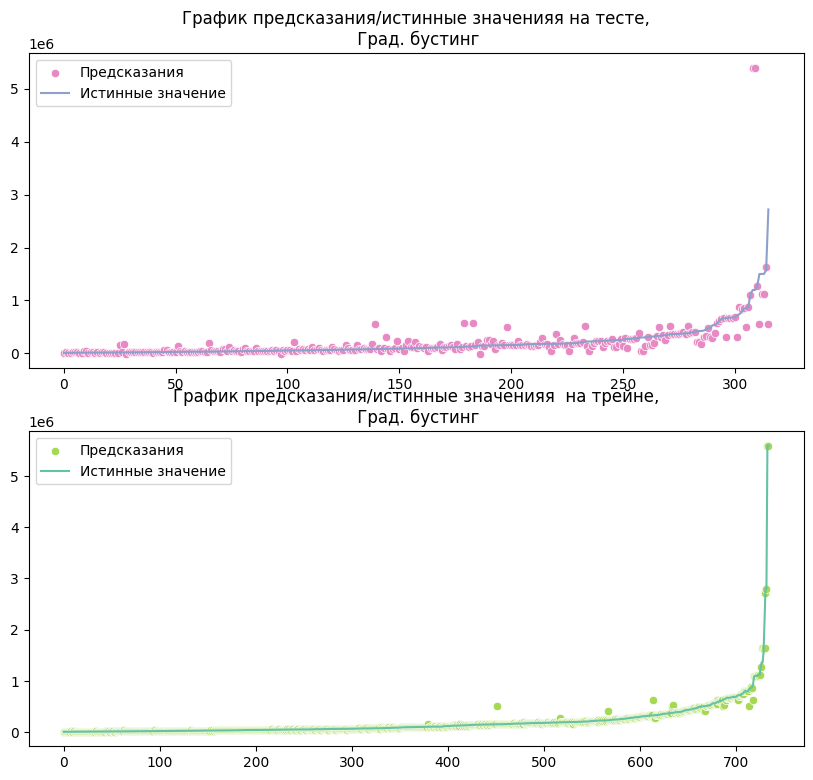

In [165]:
colors = sns.color_palette('Set2', 5)

plt.figure(figsize = (10,9))

plt.subplot(2,1,1)
plt.title('График предсказания/истинные значенияя на тесте,\n Град. бустинг')
sns.scatterplot(x = range(len(y_pred)), y = y_pred[sort_mask_test], color = colors[3], label = 'Предсказания')
sns.lineplot(x = range(len(y_test)), y = y_test.to_numpy()[sort_mask_test], 
             color = colors[2], label = 'Истинные значение')

plt.subplot(2,1,2)
plt.title('График предсказания/истинные значенияя  на трейне,\n Град. бустинг')
sns.scatterplot(x = range(len(y_train_pred)), y = y_train_pred[sort_mask_train], color = colors[4], label = 'Предсказания')
sns.lineplot(x = range(len(y_train)), y = y_train.to_numpy()[sort_mask_train], color = colors[0], label = 'Истинные значение')

plt.legend()
plt.show()

In [166]:
btg_model_feature_importances = pd.DataFrame(
    data=btg_model.feature_importances_, index=feature_names, columns=['Feature Importance']
)

btg_model_feature_importances

,Feature Importance
ohe__Размер_INT M,0.003337
ohe__Размер_INT S,0.008369
ohe__Размер_INT U,0.010469
ohe__Размер_INT XL,0.000109
ohe__Размер_INT XS,0.004449
...,...
ohe__Ценовая категория_Доступный люкс,0.001540
ohe__Ценовая категория_Люксовые,0.031157
ohe__Ценовая категория_Экстремально люксовые,0.142425
ohe__Метод производства_Произведенные на фабрике,0.003169


**Вывод:** Нет переобучения и лучшая точность из всех моделей.

---